# Imports

In [1]:
import os

# import plotting libraries
from matplotlib import pyplot as plt
import matplotlib.collections as collections
import matplotlib.patches as mpatches
import seaborn as sns
import math

# import machine learning libraries
import tensorflow as tf 
import tensorflow_io as tfio
from tensorflow import keras 
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras import Sequential

# import audio processing libraries
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import librosa.display
import librosa
from IPython.display import Audio

# import data processing libraries
from string import ascii_uppercase
from pandas import DataFrame
import itertools
from itertools import groupby
import numpy as np

# import machine learning metrics
from sklearn.metrics import confusion_matrix

# import hugging face model loading
from huggingface_hub import from_pretrained_keras


# Constants

In [2]:
SNORING_PATH = os.path.join('dataset', 'snoring')
NO_SNORING_PATH = os.path.join('dataset', 'nosnoring')

# sample files
SNORING_FILE = os.path.join(SNORING_PATH, '1_0.wav')
NO_SNORING_FILE = os.path.join(NO_SNORING_PATH, '0_0.wav')

# Helper Functions

In [39]:
# Resanokes the audio to 16KHz
def resample(waveform, sample_rate):
    waveform = waveform.numpy()
    sample_rate = sample_rate.numpy()
    return librosa.resample(waveform, orig_sr=sample_rate, target_sr=16000)


# Loads an audio file and converts it from 44KHz to 16KHz
def load_audio(filename):
    audio = tf.io.read_file(filename)
    waveform, sample_rate = tf.audio.decode_wav(audio, desired_channels=1)

    # removes trailing silence in audio
    waveform = tf.squeeze(waveform, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    waveform = tf.py_function(resample, [waveform, sample_rate], tf.float32)
    return waveform


# converts symbolic tensors to concrete tensors
def load_audio_wrapper(filename, label):
    waveform = load_audio(filename)
    return waveform, label


# Loads an audio file, converts it to a tensor, and resamples it to 16KHz mono
# Used for inferencing
def load_audio_to_tensor(filename):
    audio, sampling_rate = librosa.load(filename, sr=None, mono=True)  # load audio and convert to mono
    wave = librosa.resample(audio, orig_sr=sampling_rate, target_sr=16000)  # resample to 16KHz
    return wave

# Preprocesses audio file by taking the short-time Fourier transform
def preprocess_mp3(sample, index):
    sample = sample[0]
    sample = tf.cast(sample, tf.float32)
    zero_padding = tf.zeros([16000] - tf.shape(sample), dtype=tf.float32)
    wave = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wave, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

# Verify the Data

In [4]:
snoring16k = load_audio(SNORING_FILE)
no_snoring16k = load_audio(NO_SNORING_FILE)

C:\Users\janon\AppData\Local\Temp\ipykernel_20036\715192526.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  input_audio = read(SNORING_FILE)


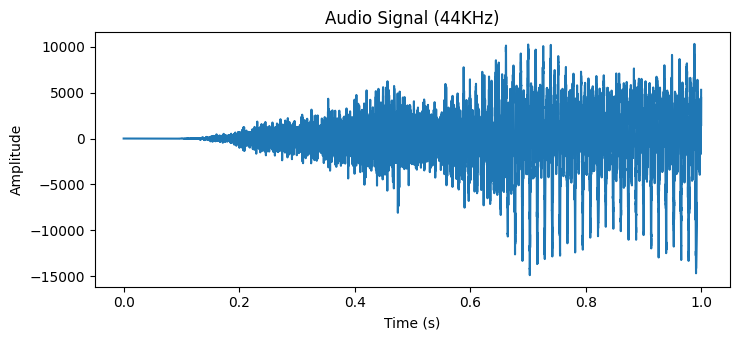

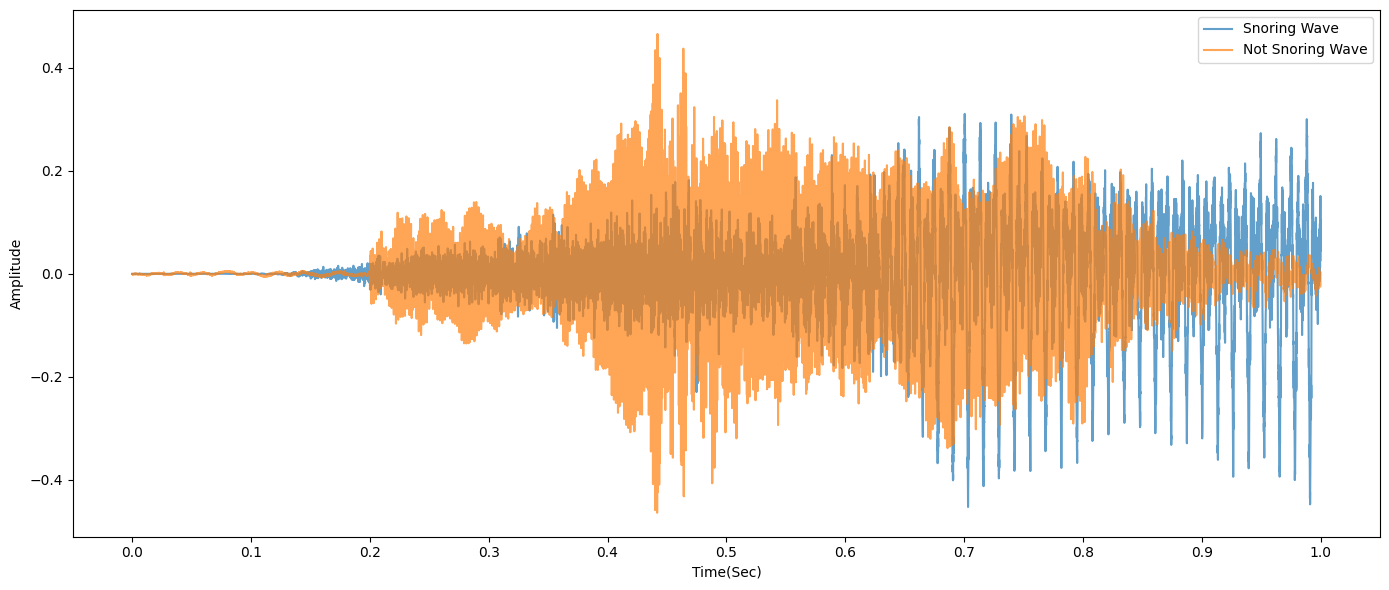

In [5]:
# plot audio file as 44KHz
plt.rcParams['figure.figsize'] = (7.5, 3.5)
plt.rcParams['figure.autolayout'] = True
input_audio = read(SNORING_FILE)
x = np.linspace(0, 1, num=len(input_audio[1]))

audio = input_audio[1]
plt.plot(x, audio)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.title('Audio Signal (44KHz)')
plt.show()

# plot snoring and no-snoring audio file as 16KHz
x = np.linspace(0, 1, 16000)
plt.figure(figsize=(14, 6))
plt.plot(x,snoring16k, alpha=0.7)
plt.plot(x,no_snoring16k, alpha=0.7)
plt.xlabel('Time(Sec)')
plt.ylabel('Amplitude')
plt.legend(labels=['Snoring Wave', 'Not Snoring Wave'])
plt.xticks(np.linspace(0, 1, 11))
plt.show()

# Load Dataset

In [6]:
snoring_set = tf.data.Dataset.list_files(SNORING_PATH + '/*.wav')
no_snoring_set = tf.data.Dataset.list_files(NO_SNORING_PATH + '/*.wav')

# create labels for the dataset; 1 for snoring and 0 for no snoring
positives = tf.data.Dataset.zip((snoring_set, tf.data.Dataset.from_tensor_slices(tf.ones(len(snoring_set)))))
negatives = tf.data.Dataset.zip((no_snoring_set, tf.data.Dataset.from_tensor_slices(tf.zeros(len(no_snoring_set)))))
dataset = positives.concatenate(negatives)

# obtains the lengths of the audio files
lengths = []
for file in os.listdir(os.path.join(NO_SNORING_PATH)):
    tensor_wave = load_audio(os.path.join(NO_SNORING_PATH, file))
    lengths.append(len(tensor_wave))

# obtain the mean, min and max lengths of the audio files
# this value must be 16000 to ensure all audio files are the same length
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=16000>

In [7]:
# preprocesses the audio
def preprocessing(waveform, label):
    # takes only the first 16000 samples
    audio = waveform[:16000]
    # pads audio shorter than 16000 samples
    padding = tf.zeros([16000] - tf.shape(audio), dtype=tf.float32)
    audio = tf.concat([padding, audio], 0)
    # obtains the short-time Fourier transform of the audio
    spectrogram = tf.signal.stft(audio, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    # adds an extra dimension to the spectrogram
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

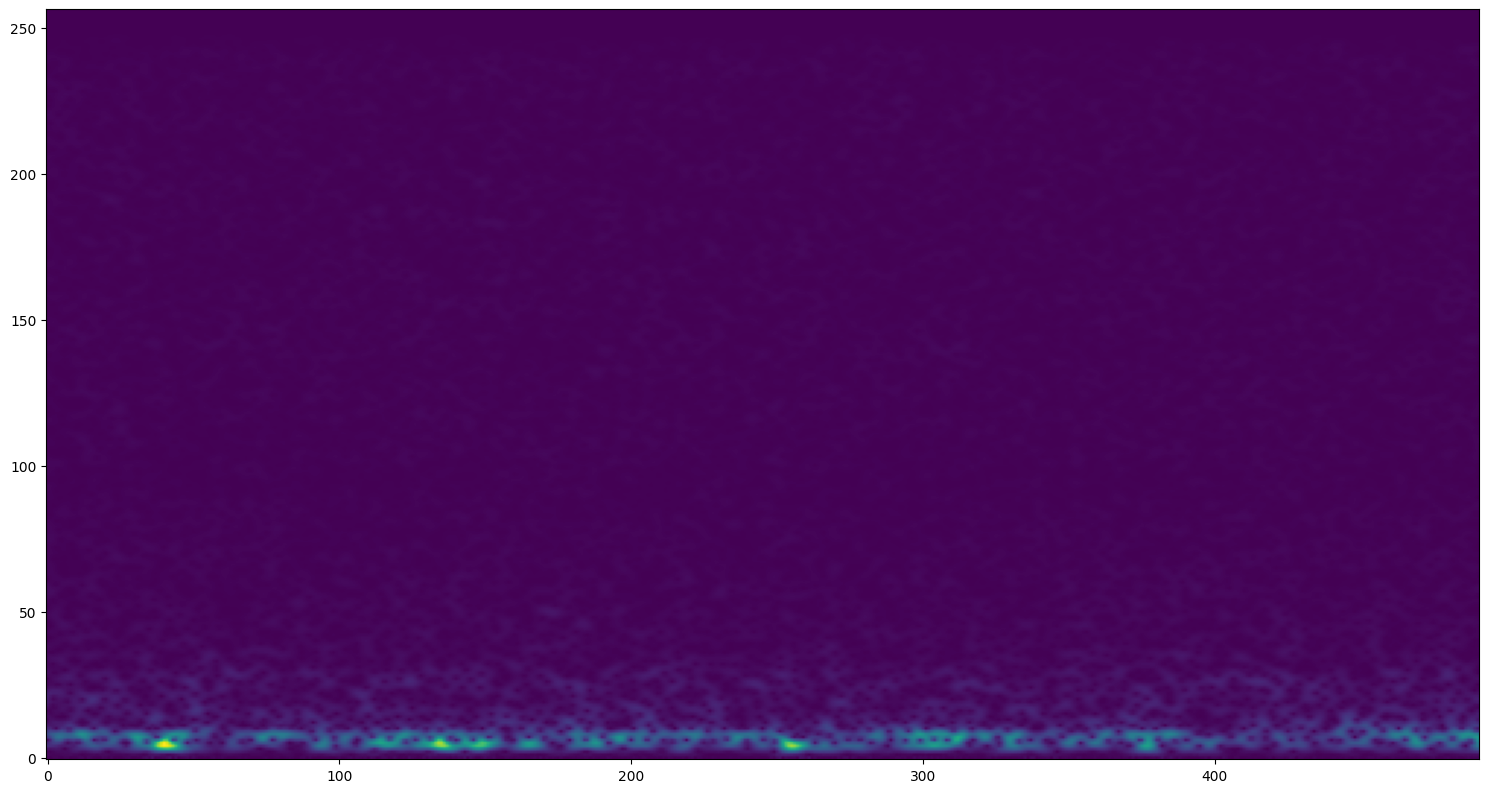

In [8]:
# shuffles the negatives dataset and load them into memory
filename, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

# load the audio from the filename
waveform, label = load_audio_wrapper(filename, label)

# test the preprocessing function and plot the spectrogram
spectrogram, label = preprocessing(waveform, label)

plt.figure(figsize=(15, 8))
plt.imshow(tf.transpose(spectrogram)[0])
plt.gca().invert_yaxis()
plt.show()

In [9]:
dataset.as_numpy_iterator().next()

dataset = dataset.map(load_audio_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.shuffle(1000)
dataset = dataset.batch(64)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
# calculates the size of the dataset for splitting into 70% training and 30% validation
total_size = len(list(dataset))
train_size = int(0.7 * total_size)
val_size = total_size - train_size

# shuffle the dataset before splitting
dataset = dataset.shuffle(total_size)

# split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# obtain the shape of the first batch of the training dataset
samples, labels = train_dataset.as_numpy_iterator().next()
samples.shape

input_shape = samples.shape[1:]

# Model Architecture

In [11]:
model = Sequential()                                                          # create a sequential model
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))     # add a convolutional layer
model.add(Conv2D(16, (3, 3), activation='relu'))                              # add another convolutional layer
model.add(Flatten())                                                          # flatten the output
model.add(Dense(128, activation='relu'))                                      # add a dense layer               
model.add(Dense(1, activation='sigmoid'))                                     # add the output layer

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()]) 

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 489, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 487, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 1971376)           0         
                                                                 
 dense (Dense)               (None, 128)               252336256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 252338865 (962.60 MB)
Trainable params: 252338865 (962.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
hist = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10



11/11 [==============================] - 95s 6s/step - loss: 20.9675 - recall: 0.6476 - precision: 0.5810 - val_loss: 5.7068 - val_recall: 0.8443 - val_precision: 0.6104
Epoch 2/10
11/11 [==============================] - 94s 9s/step - loss: 1.7407 - recall: 0.6474 - precision: 0.7321 - val_loss: 0.6525 - val_recall: 0.9434 - val_precision: 0.7353
Epoch 3/10
11/11 [==============================] - 83s 8s/step - loss: 0.4025 - recall: 0.8295 - precision: 0.8391 - val_loss: 0.2417 - val_recall: 0.9808 - val_precision: 0.9162
Epoch 4/10
11/11 [==============================] - 70s 6s/step - loss: 0.2108 - recall: 0.9652 - precision: 0.9460 - val_loss: 0.1284 - val_recall: 0.9873 - val_precision: 0.9936
Epoch 5/10
11/11 [==============================] - 81s 8s/step - loss: 0.1122 - recall: 0.9915 - precision: 0.9831 - val_loss: 0.0555 - val_recall: 0.9937 - val_precision: 0.9812
Epoch 6/10
11/11 [==============================] - 61s 6s/step - loss: 0.0549 - recall: 0.9970 - precision: 

# Model Results

In [16]:
# plot legends
loss = 'loss'
val_loss = 'val_loss'
recall = 'recall'
val_recall = 'val_recall'
precision = 'precision'
val_precision = 'val_precision'

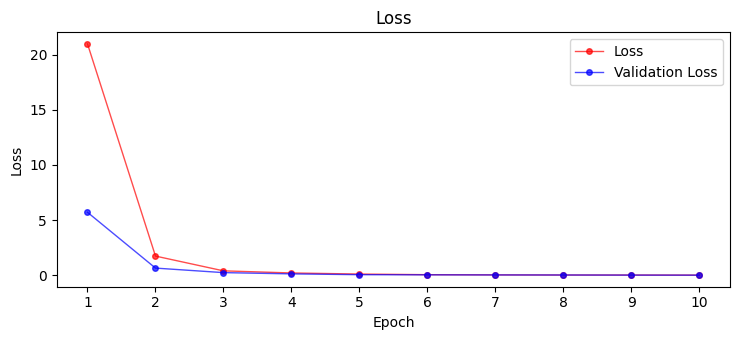

In [14]:
# loss per epoch
x_values = np.arange(1,11,1)
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (15,4)

plt.title('Loss')
plt.plot(x_values,hist.history[loss], 'r',marker='o', linewidth=1,alpha=0.7,label = 'Loss',markersize=4)
plt.plot(x_values,hist.history[val_loss], 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation Loss',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x_values)
x = x_values
y = hist.history[loss]
z = hist.history[loss]
val_z = hist.history[val_loss]
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('Loss = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-5, 25), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. Loss = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-5, 15), ha='center',
                    textcoords='offset points')
    i=i+1 
plt.show()

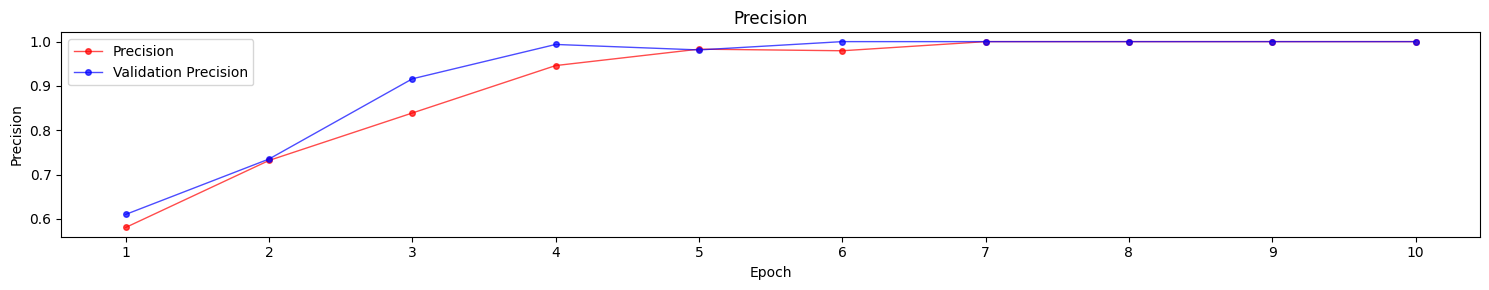

In [17]:
# precision per epoch
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (15,3)

plt.title('Precision')
plt.plot(x_values,hist.history[precision], 'r',marker='o', linewidth=1,alpha=0.7,label = 'Precision',markersize=4)
plt.plot(x_values,hist.history[val_precision], 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation Precision',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.xticks(x_values)
x = x_values
y = hist.history[precision]
z = hist.history[precision]
val_z = hist.history[val_precision]
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('Prec. = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-0, -15), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. Prec. = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-0, -25), ha='center',
                    textcoords='offset points')
    i=i+1 
plt.show()

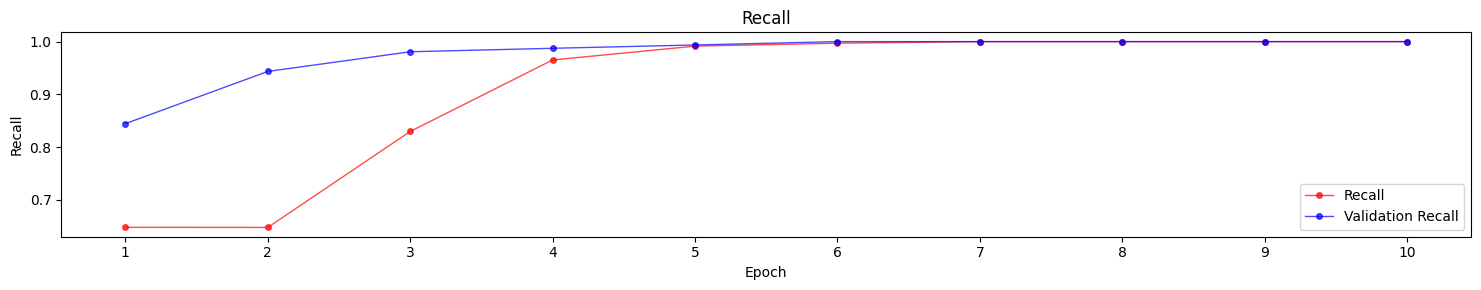

In [18]:
# recall per epoch

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (15,4)

plt.title('Recall')
ax.plot(x_values,hist.history[recall], 'r',marker='o', linewidth=1,alpha=0.7,label = 'Recall',markersize=4)
ax.plot(x_values,hist.history[val_recall], 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation Recall',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.xticks(x_values)
x = x_values
y = hist.history[recall]
z = hist.history[recall]
val_z = hist.history[val_recall]
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('Recall = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-0, -15), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. Recall = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-0, -25), ha='center',
                    textcoords='offset points')
    i=i+1    
plt.show()

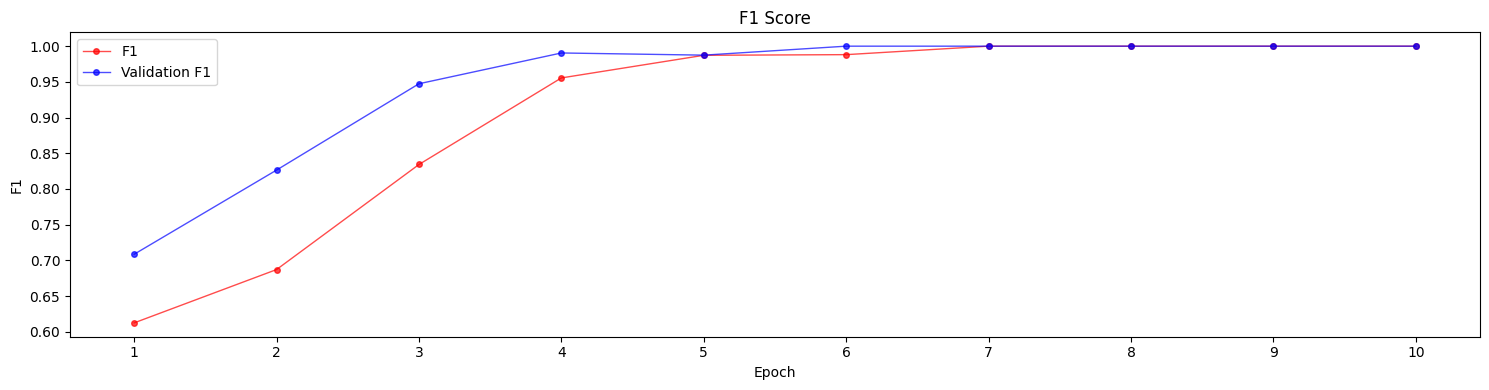

In [19]:
# f1 score per epoch
fig, ax = plt.subplots()

f1 = []
val_f1 = []
for i in range (0,len(hist.history[recall])):
    f1.append(2 * (hist.history[recall][i] * hist.history[precision][i]) / 
              (hist.history[recall][i] + hist.history[precision][i]))
    val_f1.append(2 * (hist.history[val_recall][i] * hist.history[val_precision][i]) / 
              (hist.history[val_recall][i] + hist.history[val_precision][i]))
plt.rcParams['figure.figsize'] = (14,4)

plt.title('F1 Score')
ax.plot(x_values,f1, 'r',marker='o', linewidth=1,alpha=0.7,label = 'F1',markersize=4)
ax.plot(x_values,val_f1, 'b',marker='o', linewidth=1,alpha=0.7,label = 'Validation F1',markersize=4)
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()
plt.xticks(x_values)
x = x_values
y = f1
z = f1
val_z = val_f1
i=0
for X, Y, Z,VAL_Z in zip(x, y, z,val_z):
    if i==14:
        # Annotate the points 5 _points_ above and to the left of the vertex
        ax.annotate('F1 = {}'.format(round(Z,5)), xy=(X,Y), xytext=(-0, -15), ha='center',
                    textcoords='offset points')
        ax.annotate('Val. F1 = {}'.format(round(VAL_Z,5)), xy=(X,Y), xytext=(-0, -25), ha='center',
                    textcoords='offset points')
    i=i+1 
plt.show() 

# Save Model

In [39]:
model_name = 'snore_detector.h5'
tf.keras.models.save_model(model, './saved_models/' + model_name)

C:\Users\janon\AppData\Local\Temp\ipykernel_28544\200058282.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, './saved_models/' + model_name)


# Load Model

In [15]:
# test loading the model
model_name = 'snore_detector.h5'
snore_detector = tf.keras.models.load_model('./saved_models/' + model_name)
model = snore_detector

# Model testing

2/2 [==============================] - 1s 346ms/step


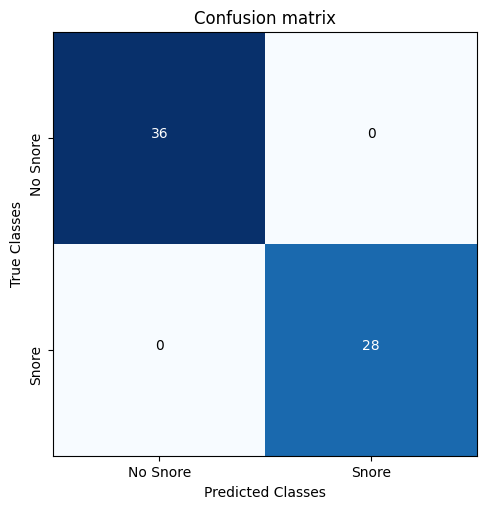

In [20]:
Xtest, ytest = val_dataset.as_numpy_iterator().next()
xtest = model.predict(Xtest)
xtest = [1 if prediction > 0.5 else 0 for prediction in xtest]
ytest.astype(int)

# classes = list(np.unique(ytest))
classes = ['No Snore', 'Snore']


# compue confusion matrix
cm = confusion_matrix(ytest.astype(int), xtest)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=0)
plt.yticks(tick_marks, classes, rotation=90)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

# Test Inferencing

In [58]:
test_audio = os.path.join('./test_audio_short2.mp3')

# loads the audio file, resamples it to 16KHz, and converts it to a tensor
wave = load_audio_to_tensor(test_audio)

In [59]:
power = sum(wave * 2) / len(wave)   # audio signal power
SNR = 3.5                           # signal-to-noise ratio
SNR_linear = 10 ** (SNR / 10)       # convert SNR to linear scale
noise_power = power / SNR_linear    # noise power

# add noise to audio to simulate environment
noise = np.random.normal(0, noise_power ** 0.5, wave.shape)  # generate noise
wave = (wave + noise) * 32768.0     # add noise to the audio signal
tensor_wave = tf.convert_to_tensor(wave, dtype=tf.float32)  # convert to tensor
min_wave = min(wave)
print(tensor_wave)


tf.Tensor(
[ -30.637892   16.458735  -84.80474  ...   -6.115496 -105.11349
 -185.01471 ], shape=(1391232,), dtype=float32)


In [60]:
# set the stride of the audio slices
if len(wave) > 16000:
    sequence_stride = 16000
else:
    sequence_stride = 16000-1

# create audio slices
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wave, wave, sequence_length=16000, sequence_stride=sequence_stride, batch_size=1)
samples, index = audio_slices.as_numpy_iterator().next()


In [61]:
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [63]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]
yhat1 = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat1).numpy()


2/2 [==============================] - 1s 276ms/step


C:\Users\janon\AppData\Local\Temp\ipykernel_20036\1117731730.py:21: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  c = collections.BrokenBarHCollection (xrange1,yrange, facecolor='red', alpha=0.2)
C:\Users\janon\AppData\Local\Temp\ipykernel_20036\1117731730.py:18: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  c = collections.BrokenBarHCollection (xrange1,yrange, facecolor='green', alpha=0.2)


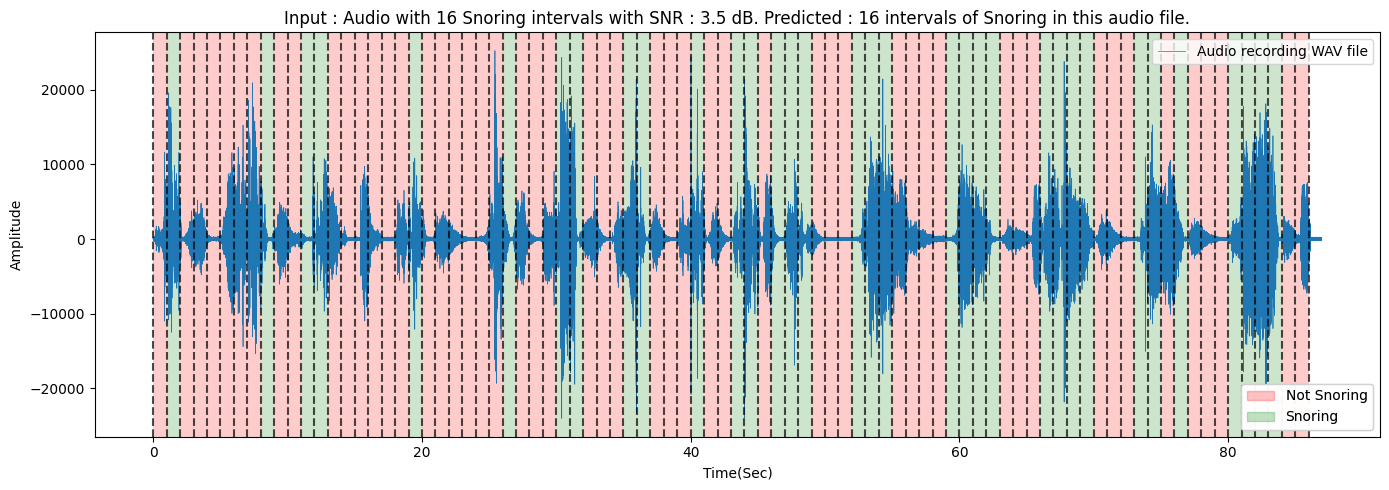

In [64]:
# plot the audio file with the snoring intervals
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (14,5)

x = np.linspace(0, len(wave)/16000, len(wave))
ax.plot(x,wave,linewidth=0.5)
plt.xlabel('Time(Sec)')
plt.ylabel('Amplitude')

for i in range(len(yhat)+1):
    x=i
    ax.axvline(x, color='black', linestyle='--',alpha=0.7)
    if i != len (yhat):
        yrange = (4*min_wave, -6*min_wave)
        xrange1 = [(i, 1)]
        color='red'

        if yhat[i]==1:
            c = collections.BrokenBarHCollection (xrange1,yrange, facecolor='green', alpha=0.2)
            ax.add_collection(c)
        else:
            c = collections.BrokenBarHCollection (xrange1,yrange, facecolor='red', alpha=0.2)
            ax.add_collection(c)
    
red_patch = mpatches.Patch(color='red', label='Not Snoring', alpha=0.2)
green_patch = mpatches.Patch(color='green', label='Snoring', alpha=0.2)

leg1 = ax.legend(labels=['Audio recording WAV file'], loc=1)
leg2 = ax.legend(handles=[red_patch,green_patch], loc=4)

ax.add_artist(leg1)
ax.add_artist(leg2)

plt.title(f'Input : Audio with {calls} Snoring intervals with SNR : {SNR} dB. Predicted : {calls} intervals of Snoring in this audio file.')
plt.show()

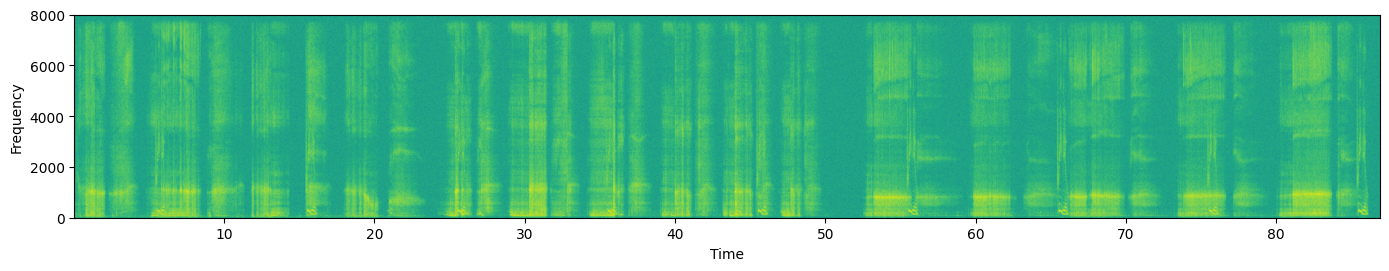

In [65]:
# plot the audio file with the snoring intervals using a spectrogram
spectrogram = tf.signal.stft(wave, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis=2)

plot_b = plt.subplot(211)
plot_b.specgram(wave, NFFT=1024, Fs=16000, noverlap=900)
plot_b.set_xlabel('Time')
plot_b.set_ylabel('Frequency')

plt.show()